In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-11 21:25:28.176865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 21:25:28.176970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 21:25:28.289239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
print(train_data.shape)
train_data.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(test_data.shape)
test_data.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convert pixel values to floats.

In [4]:
X_train = (train_data.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train_data.iloc[:,0].values.astype('int16')
X_test = test_data.values.astype('float32')

# Reshaping the DaTa
Since each image is 28x28 pixels, reshape to these dimensions.  We use a -1 to signify we want the dimension to be calculated for us.

In [5]:
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1,28,28)

Let's see what some of the images look like.

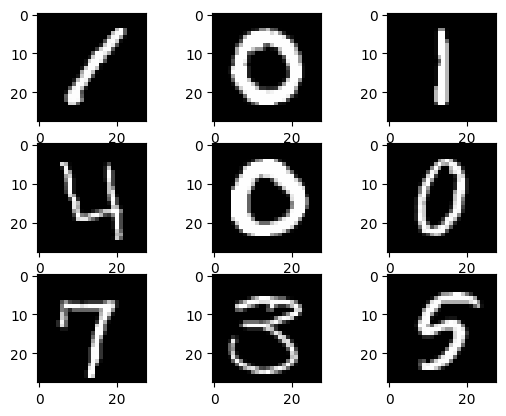

In [6]:
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

Let's have a look at this data to see what we are working with.

The training data has 42,000 images that are made up of 28x28pixels(784 in total)

In [7]:
print('X_train shape: ', X_train.shape)

X_train shape:  (42000, 28, 28)


# Data Preprocessing

In this case we will simply scale all our greyscale pixel values (0-255) to be between 0 and 1. We can do this by dividing each value in the training and testing sets by 255.0. We do this because smaller values will make it easier for the model to process our values.

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the data

In [9]:
X=X_train
y=y_train
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.10, random_state=0)

# Building the Model 

(This explanation is taken diretly from https://www.freecodecamp.org/learn/machine-learning-with-python/tensorflow/ course)

We build a feed-forward neural network using keras sequential model.  This NN has 3 different layers.

**Layer 1:** This is our input layer and it will conist of 784 neurons. We use the flatten layer with an input shape of (28,28) to denote that our input should come in in that shape. The flatten means that our layer will reshape the shape (28,28) array into a vector of 784 neurons so that each pixel will be associated with one neuron.

**Layer 2:** This is our first and only hidden layer. The dense denotes that this layer will be fully connected and each neuron from the previous layer connects to each neuron of this layer. It has 128 neurons and uses the rectify linear unit activation function.

**Layer 3:** This is our output later and is also a dense layer. It has 10 neurons that we will look at to determine our models output. Each neuron represnts the probabillity of a given image being one of the 10 different classes. The activation function softmax is used on this layer to calculate a probabillity distribution for each class. This means the value of any neuron in this layer will be between 0 and 1, where 1 represents a high probabillity of the image being that class.

In [10]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(10, activation='softmax') # output layer (3)
])

# Compiling the Model.  

We define a sparse categorical crossentropy loss function.

When classifying digits, sparse categorical cross-entropy is often preferred for several reasons:

**Sparse Labels:** In digit classification tasks, the labels are typically represented as integers (0 to 9 for digits), and each digit corresponds to a unique class. In such cases, the labels are sparse, meaning they are not one-hot encoded. Sparse categorical cross-entropy is designed to handle such sparse labels efficiently.

**Efficiency:** Sparse categorical cross-entropy is computationally efficient compared to its counterpart, categorical cross-entropy, especially when dealing with large numbers of classes. Since the label is an integer index rather than a one-hot encoded vector, the computation is simplified.

**Memory Efficiency:** Sparse categorical cross-entropy requires less memory to store the labels compared to one-hot encoded labels, which can be crucial when dealing with large datasets or models with a large number of classes.

**Interpretability:** Using sparse categorical cross-entropy allows for more interpretable outputs. Instead of getting a one-hot encoded vector as output, you get a single integer representing the predicted class, which can be easier to interpret and work with, especially in applications where human readability is important.

Overall, sparse categorical cross-entropy is well-suited for classification tasks where the labels are integers representing class indices, such as digit classification, and it offers computational and memory advantages over other loss functions like categorical cross-entropy.

"Why should you use a sparse categorical crossentropy loss function when classifying digits" prompt. ChatGPT, 3.5, OpenAI, 11 Feb. 2024. https://chat.openai.com.

# Early Stopping
Add a callback function to prevent a model from eagerly learning noise.  We stop the training whenever it seems the validation loss isn't decreasing anymore.  Since the call back function determines the best stopping point, we set our epochs high.


In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping])

Epoch 1/1000


I0000 00:00:1707686749.298115      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 [==============================] - 2s 6ms/step - loss: 0.7527 - accuracy: 0.7985 - val_loss: 0.3438 - val_accuracy: 0.9057
Epoch 2/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2911 - accuracy: 0.9193 - val_loss: 0.2710 - val_accuracy: 0.9269
Epoch 3/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2305 - accuracy: 0.9352 - val_loss: 0.2310 - val_accuracy: 0.9388
Epoch 4/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.1924 - accuracy: 0.9458 - val_loss: 0.2079 - val_accuracy: 0.9443
Epoch 5/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.1651 - accuracy: 0.9538 - val_loss: 0.1891 - val_accuracy: 0.9490
Epoch 6/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.1455 - accuracy: 0.9589 - val_loss: 0.1742 - val_accuracy: 0.9529
Epoch 7/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.1296 - accuracy: 0.9634 - val_loss: 0.1667 - val_accuracy: 0.9540
Epoch 8/1000
74/74 

In [12]:
# history_df = pd.DataFrame(history.history)
# history_df.loc[:, ['loss', 'val_loss']].plot();
# print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# The following graphs show how early stopping prevents overfitting

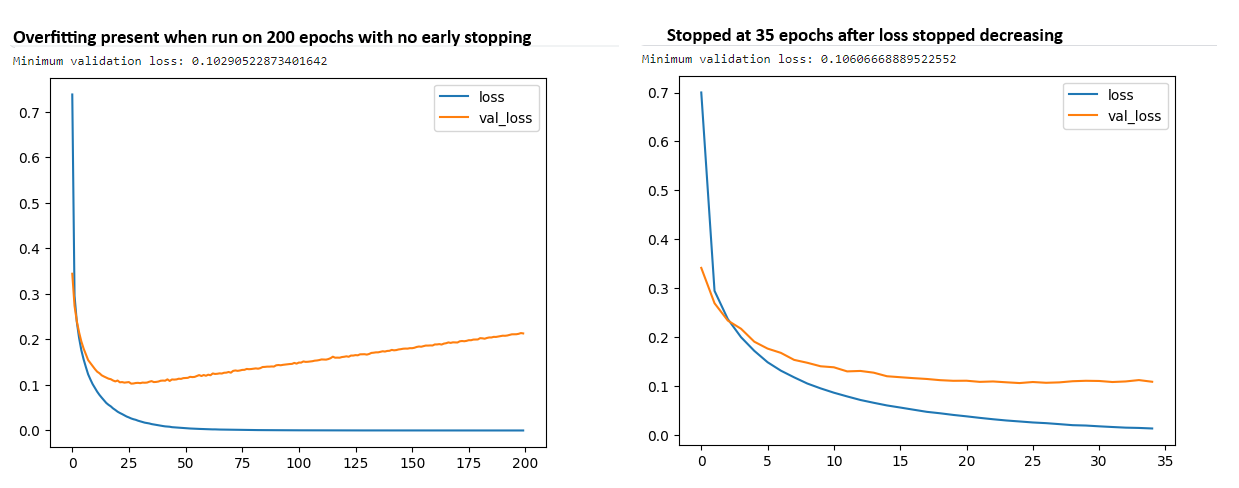

# Making Predictions
To make predictions we simply need to pass an array of data in the form we've specified in the input layer to ```.predict()``` method.

In [13]:
predictions = model.predict(X_val)

132/132 [==============================] - 0s 1ms/step


# Verifying predcitions

The following script had to be commented out since no user input is permitted for Kaggle's submissions.
Uncomment to input a item number and see an image of the data for that item , the model's prediction, and the actual value.

In [14]:
# def show_image(img):
#   plt.figure()
#   plt.imshow(img, cmap=plt.cm.binary)
#   plt.grid(False)
#   plt.show()
  
# def get_number():
#   while True:
#     num = input("Pick a number: ")
#     if num.isdigit():
#       num = int(num)
#       if 0 <= num < 4200:
#         return int(num)
#       else:
#         print("Try again...")
#     else:
#         print("Try again...")

# num = get_number()
# show_image(X_val[num])
# print('Predicated value: ', np.argmax(predictions[num]))
# print('Actual number: ', y_val[num])

# A sample output of the previous script:

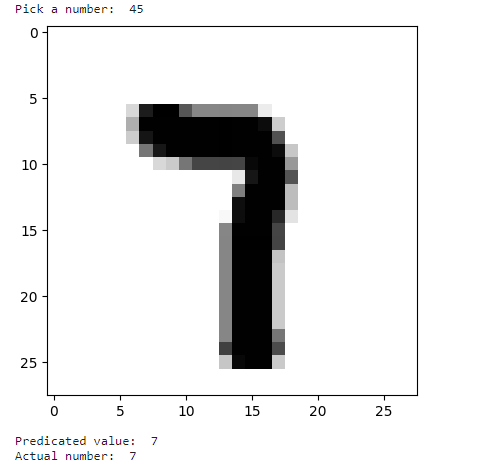

In [15]:
predictions = model.predict(X_test)
X_test.shape

875/875 [==============================] - 1s 1ms/step


(28000, 28, 28)

In [16]:
predictions = np.argmax(predictions, axis = 1)
predictions = pd.Series(predictions,name = "Label")

In [17]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"),predictions],axis = 1)
submission.to_csv("DR.csv", index = False)